In [215]:
!pip install ipywidgets

In [1]:
import requests
import json
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import pprint
import re
import nbformat
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from datetime import datetime
from ipywidgets import interact, widgets
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
with open("../DataProcessing/TestData/message.json", "r") as file:
    data = json.load(file)
    
with open("../DataProcessing/TestData/postGame.json", "r") as file:
    postData = json.load(file)
    
with open("../DataProcessing/TestData/runeSheet.json", "r") as file:
    runeSheet = json.load(file)
    
participantsData = data['metadata']['participants']
framesData = data['info']['frames']
participantFrames = [frame['participantFrames'] for frame in framesData]

championCountsDict = defaultdict(lambda: defaultdict(int))
namesDict = defaultdict(list)

mostMentionedNamesDict = {}
participantData = []
participantChampionMapping = {}


In [3]:
targetPuuid = 'NLZhdGCfh-EgdvaODKW2IlCFzJBMtE4Dr9SFgKNpE1UC6GDNH2u2TQmGZoqSLXcVjo-erCaRQVV0cQ'

In [4]:
# Function to calculate champion counts
def calculateChampionCounts(data):
    championCountsDict = {}
    namesDict = {}

    if 'info' in data and 'frames' in data['info']:
        for frame in data['info']['frames']:
            for event in frame.get('events', []):
                if event['type'] == 'CHAMPION_KILL':
                    killerId = int(event.get('killerId'))
                    victimId = int(event.get('victimId'))

                    if killerId not in championCountsDict:
                        championCountsDict[killerId] = {}
                        namesDict[killerId] = []

                    if victimId not in championCountsDict:
                        championCountsDict[victimId] = {}
                        namesDict[victimId] = []

                    # Find the killer's and victim's participant data
                    killerNames = [victim.get('name') for victim in event.get('victimDamageReceived', [])]
                    victimNames = [killer.get('name') for killer in event.get('victimDamageDealt', [])]

                    # Use the last name mentioned as the killer name
                    if killerNames:
                        killerName = killerNames[-1]
                        if killerName not in championCountsDict[killerId]:
                            championCountsDict[killerId][killerName] = 1
                        else:
                            championCountsDict[killerId][killerName] += 1
                        namesDict[killerId].append(killerName)

                    # Use the last name mentioned as the victim name
                    if victimNames:
                        victimName = victimNames[-1]
                        if victimName not in championCountsDict[victimId]:
                            championCountsDict[victimId][victimName] = 1
                        else:
                            championCountsDict[victimId][victimName] += 1
                        namesDict[victimId].append(victimName)
    return championCountsDict, namesDict

def calculateMostMentionedChampionNames(data):
    # Calculate champion counts
    championCountsDict, namesDict = calculateChampionCounts(data)

    # Process the counts and choose the most mentioned champion name for each ID
    mostMentionedNamesDict = {}
    for participantId, championCounts in championCountsDict.items():
        mostMentionedChampion = max(championCounts, key=championCounts.get)
        mostMentionedNamesDict[participantId] = mostMentionedChampion
        count = championCounts[mostMentionedChampion]
        names = namesDict[participantId]
    return mostMentionedNamesDict

mostMentionedNamesDict = calculateMostMentionedChampionNames(data)

In [5]:
def addParticipantData(participantId, puuid, championName):  # add championName
    participantData.append([participantId, puuid, championName])  # add championName

def findParticipantData(data):
    if 'info' in data and 'participants' in data['info']:
        for participant in data['info']['participants']:
            participantId = participant['participantId']
            puuid = participant['puuid']
            
            championName = mostMentionedNamesDict[participantId]
            addParticipantData(participantId, puuid, championName)
findParticipantData(data)

def findParticipantByPuuid(participantData, targetPuuid):
    for entry in participantData:
        participantId, puuid, championName = entry
        if puuid == targetPuuid:
            return participantId, championName
    return None, None

targetParticipantId, targetChampionName = findParticipantByPuuid(participantData, targetPuuid)

if targetParticipantId is not None:
    print(f"Participant ID: {targetParticipantId}, Champion: {targetChampionName}")
else:
    print("Participant not found.")

Participant ID: 5, Champion: Senna


In [6]:
def excludeColumns(data, columnsToExclude=None, displayNoZero=False):
    # Exclude specified columns
    excludedData = {}

    for key, value in data.items():
        if key in columnsToExclude:
            continue  # Skip excluded columns
        elif isinstance(value, dict):
            # Recursively exclude columns within nested dictionaries
            excludedData[key] = excludeColumns(value, columnsToExclude, displayNoZero)
        else:
            excludedData[key] = value
    return excludedData

def displayNonZeroParams(participantFrame, displayNoZero=False, indent=''):
    # Iterate through the participant frame's items
    for key, value in participantFrame.items():
        if isinstance(value, dict):
            # If the value is a nested dictionary, iterate through its items
            print(f"{indent}{key} for {targetChampionName}: ")
            displayNonZeroParams(value, displayNoZero, indent + '  ')
        elif isinstance(value, (int, float)) and (not displayNoZero or value != 0):
            # Display the parameter if it's a numeric value and not zero
            print(f"{indent}  {key}: {value}")

def getParticipantDataAtMinute(data, participantId, targetMinute, columnsToExclude=None, displayNoZero=False):
    timestampData = []

    # Check if there are frames in the data
    if 'info' in data and 'frames' in data['info']:
        for frame in data['info']['frames']:
            timestamp = frame['timestamp']
            currentMinute = round(timestamp / 60000)  # Convert milliseconds to minutes and round to the nearest minute

            if currentMinute == targetMinute:
                participantFrames = frame.get('participantFrames', {})
                if participantId in participantFrames:
                    participantData = participantFrames[participantId]
                    timestampData.append([timestamp, participantData])

                    # Call the excludeColumns method
                    excludedData = excludeColumns(participantData, columnsToExclude, displayNoZero)

                    # Display either the original data or the excluded data based on your requirement
                    if displayNoZero:
                        print(f"Timestamp at minute {targetMinute}: {timestamp}")
                        displayNonZeroParams(excludedData, displayNoZero)
                        print("\n---\n")
                    else:
                        print(f"Timestamp at minute {targetMinute}: {timestamp}")
                        displayNonZeroParams(participantData, displayNoZero)
                        print("\n---\n")
    return timestampData

desiredParticipantId = (f"{targetParticipantId}")
desiredMinute = 2 
columnsToExclude = ['magicDamageDone', 'magicDamageDoneToChampions', 'magicDamageTaken', 
                    'physicalDamageDone', 'physicalDamageDoneToChampions', 'physicalDamageTaken', 
                    'trueDamageDone', 'trueDamageDoneToChampions', 'trueDamageTaken', 'timeEnemySpentControlled']

# Call the function with displayNoZero set to True
#result = getParticipantDataAtMinute(data, desiredParticipantId, desiredMinute, columnsToExclude=columnsToExclude, displayNoZero=True)


In [204]:
def getKillDataForParticipant(data, participantId, participantData):
    killData = []

    if 'info' in data and 'frames' in data['info']:
        for frame in data['info']['frames']:
            for event in frame.get('events', []):
                if event['type'] == 'CHAMPION_KILL':
                    killerId = int(event.get('killerId'))
                    victimId = int(event.get('victimId'))
                    assistIds = [int(assistId) for assistId in event.get('assistingParticipantIds', [])]

                    if killerId == participantId:
                        timestamp = round(event['timestamp'] / 60000, 2)
                        victimDamageReceived = event.get('victimDamageReceived', [])
                        killPosition = event.get('position', {})  # Added line

                        # Calculate total damage done by the killer to the victim
                        totalDamageDone = sum(
                            damageInfo['basic'] + damageInfo['magicDamage'] + damageInfo['physicalDamage'] + damageInfo['trueDamage']
                            for damageInfo in victimDamageReceived
                            if damageInfo['participantId'] == participantId
                        )

                        # Find names from participantData
                        killerName = next((participant[2] for participant in participantData if participant[0] == killerId),
                                           f"Unknown Champion with ID {killerId}")
                        victimName = next((participant[2] for participant in participantData if participant[0] == victimId),
                                           f"Unknown Champion with ID {victimId}")

                        # Find names of assisting champions and their damage
                        assistingChampions = []
                        damageByAssists = []

                        for assistId in assistIds:
                            assistName = next((participant[2] for participant in participantData if participant[0] == assistId),
                                               f"Unknown Champion with ID {assistId}")

                            assistDamage = sum(
                                damageInfo['basic'] + damageInfo['magicDamage'] + damageInfo['physicalDamage'] + damageInfo['trueDamage']
                                for damageInfo in victimDamageReceived
                                if damageInfo['participantId'] == assistId
                            )

                            assistingChampions.append(assistName)
                            damageByAssists.append(assistDamage)

                        killData.append({
                            'timestamp': timestamp,
                            'killerId': killerId,
                            'killerName': killerName,
                            'victimId': victimId,
                            'victimName': victimName,
                            'totalDamageDone': totalDamageDone,
                            'assistingChampions': assistingChampions,
                            'damageByAssists': damageByAssists,
                            'position': killPosition  # Added line
                        })
    return killData

killDataForParticipant = getKillDataForParticipant(data, targetParticipantId, participantData)


def getAssistsForParticipant(data, targetParticipantId, participantData):
    assistData = []

    if 'info' in data and 'frames' in data['info']:
        for frame in data['info']['frames']:
            for event in frame.get('events', []):
                if event['type'] == 'CHAMPION_KILL':
                    killerId = int(event.get('killerId'))
                    assistIds = [int(assistId) for assistId in event.get('assistingParticipantIds', [])]

                    if targetParticipantId in assistIds:
                        timestamp = round(event['timestamp'] /60000, 2)
                        
                        # Get the name and ID of the killer
                        killerName = next((participant[2] for participant in participantData if participant[0] == killerId),
                                          f"Unknown Champion with ID {killerId}")

                        killerParticipantId = killerId

                        assistData.append({
                            'timestamp': timestamp,
                            'killerId': killerParticipantId,
                            'killerName': killerName,
                            'assistId': targetParticipantId,
                            'assistName': next((participant[2] for participant in participantData if participant[0] == targetParticipantId),
                                               f"Unknown Champion with ID {targetParticipantId}"),
                            'position': event.get('position', {'x': 0, 'y': 0})  # Use default coordinates if not present
                        })
    return assistData

assistDataForParticipant = getAssistsForParticipant(data, targetParticipantId, participantData)

def getDeathsForParticipant(data, targetParticipantId, participantData):
    deathData = []

    if 'info' in data and 'frames' in data['info']:
        for frame in data['info']['frames']:
            for event in frame.get('events', []):
                if event['type'] == 'CHAMPION_KILL':
                    victimId = int(event.get('victimId'))
                    killerId = int(event.get('killerId'))

                    if victimId == targetParticipantId:
                        timestamp = round(event['timestamp'] / 60000, 2)

                        # Get the name and ID of the killer
                        killerName = next((participant[2] for participant in participantData if participant[0] == killerId),
                                          f"Unknown Champion with ID {killerId}")

                        killerParticipantId = killerId

                        deathData.append({
                            'timestamp': timestamp,
                            'victimId': targetParticipantId,
                            'victimName': next((participant[2] for participant in participantData if participant[0] == targetParticipantId),
                                               f"Unknown Champion with ID {targetParticipantId}"),
                            'killerId': killerParticipantId,
                            'killerName': killerName,
                            'position': event.get('position', {'x': 0, 'y': 0})  # Use default coordinates if not present
                        })
    return deathData

#deathLocation = f"X: {death['position'].get('x', 0)}, Y: {death['position'].get('y', 0)}"

deathDataForParticipant = getDeathsForParticipant(data, targetParticipantId, participantData)

In [205]:
for assist in assistDataForParticipant:
    assistLocation = f"X: {assist['position'].get('x', 0)}, Y: {assist['position'].get('y', 0)}"

    print(f"Timestamp: {assist['timestamp']}\n"
          f"Killer: {assist['killerName']} (ID: {assist['killerId']})\n"
          f"Assist: {assist['assistName']} (ID: {assist['assistId']})\n"
          f"Assist Location: ({assistLocation})\n")


Timestamp: 0.69
Killer: TahmKench (ID: 4)
Assist: Senna (ID: 5)
Assist Location: (X: 11310, Y: 3599)

Timestamp: 3.02
Killer: TahmKench (ID: 4)
Assist: Senna (ID: 5)
Assist Location: (X: 12792, Y: 1251)

Timestamp: 6.27
Killer: TahmKench (ID: 4)
Assist: Senna (ID: 5)
Assist Location: (X: 12243, Y: 1559)

Timestamp: 9.08
Killer: Xerath (ID: 3)
Assist: Senna (ID: 5)
Assist Location: (X: 10038, Y: 5593)

Timestamp: 11.25
Killer: TahmKench (ID: 4)
Assist: Senna (ID: 5)
Assist Location: (X: 12877, Y: 2611)

Timestamp: 12.47
Killer: TahmKench (ID: 4)
Assist: Senna (ID: 5)
Assist Location: (X: 11863, Y: 7301)

Timestamp: 13.07
Killer: TahmKench (ID: 4)
Assist: Senna (ID: 5)
Assist Location: (X: 13937, Y: 4925)

Timestamp: 13.74
Killer: Kindred (ID: 2)
Assist: Senna (ID: 5)
Assist Location: (X: 12244, Y: 7591)

Timestamp: 13.78
Killer: Kindred (ID: 2)
Assist: Senna (ID: 5)
Assist Location: (X: 13423, Y: 7965)



In [206]:
for kill in killDataForParticipant:
    
    killLocation = f"X: {kill['position'].get('x', 0)}, Y: {kill['position'].get('y', 0)}"

    assistingChampionsLine = f"Assisting Champions: {', '.join(kill['assistingChampions'])}.\n" if kill['assistingChampions'] else ""
    damageByAssistsLine = f"Damage Done by Assists: {', '.join([f'{damage} by {assist}' for damage, assist in zip(kill['damageByAssists'], kill['assistingChampions'])])}.\n" if kill['assistingChampions'] else ""

    print(f"Timestamp: {kill['timestamp']}\n"
          f"Killer: {kill['killerName']} (ID: {kill['killerId']})\n"
          f"Victim: {kill['victimName']} (ID: {kill['victimId']})\n"
          f"Total Damage Done: {kill['totalDamageDone']}\n"
          f"{assistingChampionsLine}"
          f"{damageByAssistsLine}"
          f"Kill Location: ({killLocation})\n")

Timestamp: 6.99
Killer: Senna (ID: 5)
Victim: Udyr (ID: 7)
Total Damage Done: 449
Assisting Champions: TahmKench.
Damage Done by Assists: 323 by TahmKench.
Kill Location: (X: 13701, Y: 4736)

Timestamp: 12.17
Killer: Senna (ID: 5)
Victim: Nautilus (ID: 10)
Total Damage Done: 821
Assisting Champions: TahmKench.
Damage Done by Assists: 598 by TahmKench.
Kill Location: (X: 13411, Y: 7350)

Timestamp: 13.01
Killer: Senna (ID: 5)
Victim: Ashe (ID: 9)
Total Damage Done: 381
Assisting Champions: TahmKench.
Damage Done by Assists: 348 by TahmKench.
Kill Location: (X: 13596, Y: 4559)



In [207]:
def getTakedowns(postData, targetPuuid):
    for participant in postData['info']['participants']:
        if participant.get('puuid') == targetPuuid:
            takedowns = participant.get('challenges', {}).get('takedowns', None)
            if takedowns is not None:
                print(f"  Takedowns by {targetChampionName}: {takedowns}")
            else:
                print(f"No Data for Takedowns by {targetChampionName}")
    return None

def getKda(postData, targetPuuid):
    for participant in postData['info']['participants']:
        if participant.get('puuid') == targetPuuid:
            kda = participant.get('challenges', {}).get('kda', None)
            if kda is not None:
                print(f"  KDA by {targetChampionName}: {kda}\n")
            else:
                print(f"No KDA found for {targetChampionName}\n")
    return None

def getSoloKills(postData, targetPuuid):
    for participant in postData['info']['participants']:
        if participant.get('puuid') == targetPuuid:
            soloKills = participant.get('challenges', {}).get('soloKills', None)
            if soloKills is not None:
                print(f"  Solo Kills for {targetChampionName}: {soloKills}")
            else:
                print(f"No kill participation found for {targetChampionName}")
    return None
    
def getKillParticipation(postData, targetPuuid):
    for participant in postData['info']['participants']:
        if participant.get('puuid') == targetPuuid:
            killParticipation = participant.get('challenges', {}).get('killParticipation', None)
            if killParticipation is not None:
                print(f"  Kill Participation for {targetChampionName}: {killParticipation}")
            else:
                print(f"No kill participation found for {targetChampionName}")
            return killParticipation
    return None    

def getLaneRole(postData, targetPuuid):
    for participant in postData['info']['participants']:
        if participant.get('puuid') == targetPuuid:
            laneRole = participant.get('individualPosition', None)
            if laneRole is not None:
                print(f"Role of {targetChampionName}: {laneRole}")
            return laneRole
    return None  
    
def getJungleStats(postData, targetPuuid):
    for participant in postData['info']['participants']:
        if participant.get('puuid') == targetPuuid and participant.get('individualPosition') == 'JUNGLE':
            totalAllyJungleMinionsKilled = participant.get('totalAllyJungleMinionsKilled', None)
            totalEnemyJungleMinionsKilled = participant.get('totalEnemyJungleMinionsKilled', None)
            if totalAllyJungleMinionsKilled is not None and totalEnemyJungleMinionsKilled is not None:
                print(f"  Total Ally Jungle Minions Killed: {totalAllyJungleMinionsKilled}")
                print(f"  Total Enemy Jungle Minions Killed: {totalEnemyJungleMinionsKilled}\n")
            return totalAllyJungleMinionsKilled, totalEnemyJungleMinionsKilled
    return None, None

def getTeamSide(postData, targetPuuid):
    for participant in postData['info']['participants']:
        if participant.get('puuid') == targetPuuid:
            teamSide = participant.get('teamId', None)
            if teamSide is not None:
                if teamSide == 100:
                    print(f"{targetChampionName} was Blue Side")
                else:
                    print(f"{targetChampionName} was Red Side")
            return teamSide
    return None

def getGameWon(postData, targetPuuid):
    for participant in postData['info']['participants']:
        if participant.get('puuid') == targetPuuid:
            gameWon = participant.get('win', None)
            if gameWon is not None:
                if gameWon == True:
                    print(f"{targetChampionName}s Team Won the Game")
                else:
                    print(f"{targetChampionName}s Team Lost the Game")        
            return
    return None

def getTotalDamageDealt(postData, targetPuuid):
    for participant in postData['info']['participants']:
        if participant.get('puuid') == targetPuuid:
            totalDamageDealt = participant.get('totalDamageDealt', None)
            if totalDamageDealt is not None:
                print(f"  Total Damage Dealt by {targetChampionName}: {totalDamageDealt}")
    return None

def getTotalDamageDealtToChampions(postData, targetPuuid):
    for participant in postData['info']['participants']:
        if participant.get('puuid') == targetPuuid:
            totalDamageDealtToChampions = participant.get('totalDamageDealtToChampions', None)
            if totalDamageDealtToChampions is not None:
                print(f"  Total Damage Dealt To Champions by {targetChampionName}: {totalDamageDealtToChampions}")
    return None

def getTotalDamageTaken(postData, targetPuuid):
    for participant in postData['info']['participants']:
        if participant.get('puuid') == targetPuuid:
            totalDamageTaken = participant.get('totalDamageTaken', None)
            if totalDamageTaken is not None:
                print(f"  Total Damage Taken for {targetChampionName}: {totalDamageTaken}\n")
    return None

def getDeathsByEnemyChamps(postData, targetPuuid):
    for participant in postData['info']['participants']:
        if participant.get('puuid') == targetPuuid:
            deathsByEnemyChamps =  participant.get('challenges', {}).get('deathsByEnemyChamps', None)
            if deathsByEnemyChamps is not None:
                print(f"  Deaths by Enemy Champions on {targetChampionName}: {deathsByEnemyChamps}")
    return None

def getTeamBaronKills(postData, targetPuuid):
    for participant in postData['info']['participants']:
        if participant.get('puuid') == targetPuuid:
            teamBaronKills = participant.get('challenges', {}).get('teamBaronKills', None)
            if teamBaronKills is not None and teamBaronKills != 0:
                print(f"  Team Baron Kills by {targetChampionName}: {teamBaronKills}")
    return None

def getTeamRiftHeraldKills(postData, targetPuuid):
    for participant in postData['info']['participants']:
        if participant.get('puuid') == targetPuuid:
            teamRiftHeraldKills = participant.get('challenges', {}).get('teamRiftHeraldKills', None)
            if teamRiftHeraldKills is not None and teamRiftHeraldKills != 0:
                print(f"  Team Rift Herald Kills by {targetChampionName}: {teamRiftHeraldKills}")
    return None

def getTeamElderDragonKills(postData, targetPuuid):
    for participant in postData['info']['participants']:
        if participant.get('puuid') == targetPuuid:
            teamElderDragonKills = participant.get('challenges', {}).get('teamElderDragonKills', None)
            if teamElderDragonKills is not None and teamElderDragonKills != 0:
                print(f"  Team Elder Dragon Kills by {targetChampionName}: {teamElderDragonKills}")
    return None

def getDragonTakedowns(postData, targetPuuid):
    for participant in postData['info']['participants']:
        if participant.get('puuid') == targetPuuid:
            dragonTakedowns = participant.get('challenges', {}).get('dragonTakedowns', None)
            if dragonTakedowns is not None and dragonTakedowns != 0:
                print(f"  Dragon Takedowns by {targetChampionName}: {dragonTakedowns}")
    return None

def getVisionScoreAdvantageLaneOpponent(postData, targetPuuid):
    for participant in postData['info']['participants']:
        if participant.get('puuid') == targetPuuid:
            visionScoreAdvantage = participant.get('challenges', {}).get('visionScoreAdvantageLaneOpponent')
            if visionScoreAdvantage is not None:
                print(f"  Vision Score Advantage for {targetChampionName}: {visionScoreAdvantage}")
    return None

def getTurretTakedowns(postData, targetPuuid):
    for participant in postData['info']['participants']:
        if participant.get('puuid') == targetPuuid:
            turretTakedowns = participant.get('challenges', {}).get('turretTakedowns', None)
            if turretTakedowns is not None and turretTakedowns != 0:
                print(f"  Turret Takedowns by {targetChampionName}: {turretTakedowns}\n")  
    return None

def getVisionScore(postData, targetPuuid):
    for participant in postData['info']['participants']:
        if participant.get('puuid') == targetPuuid:
            visionScore = participant.get('visionScore', None)
            if visionScore is not None:
                print(f"  Vison Score for {targetChampionName}: {visionScore}")
    return None

def getControlWardTimeCoverageInRiverOrEnemyHalf(postData, targetPuuid):
    for participant in postData['info']['participants']:
        if participant.get('puuid') == targetPuuid:
            controlWardTimeCoverageInRiverOrEnemyHalf = participant.get('challenges', {}).get('controlWardTimeCoverageInRiverOrEnemyHalf', None)
            if controlWardTimeCoverageInRiverOrEnemyHalf is not None and controlWardTimeCoverageInRiverOrEnemyHalf != 0:
                print(f"  Control Ward Time Coverage In River or Enemy Half for {targetChampionName}: {controlWardTimeCoverageInRiverOrEnemyHalf}")
    return None

def getControlWardsPlaced(postData, targetPuuid):
    for participant in postData['info']['participants']:
        if participant.get('puuid') == targetPuuid:
            controlWardsPlaced = participant.get('challenges', {}).get('controlWardsPlaced', None)
            if controlWardsPlaced is not None and controlWardsPlaced != 0:
                print(f"  Control Wards placed by {targetChampionName}: {controlWardsPlaced}")
    return None

def getStealthWardsPlaced(postData, targetPuuid):
    for participant in postData['info']['participants']:
        if participant.get('puuid') == targetPuuid:
            stealthWardsPlaced = participant.get('challenges', {}).get('stealthWardsPlaced', None)
            if stealthWardsPlaced is not None and stealthWardsPlaced != 0:
                print(f"  Stealth Wards Placed by {targetChampionName}: {stealthWardsPlaced}")
    return None

def getWardsKilled(postData, targetPuuid):
    for participant in postData['info']['participants']:
        if participant.get('puuid') == targetPuuid:
            wardsKilled = participant.get('wardsKilled', None)
            if wardsKilled is not None and wardsKilled != 0:
                print(f"  Wards Killed by {targetChampionName}: {wardsKilled}\n")
    return None

def getWardsPlaced(postData, targetPuuid):
    for participant in postData['info']['participants']:
        if participant.get('puuid') == targetPuuid:
            wardsPlaced = participant.get('wardsPlaced', None)
            if wardsPlaced is not None and wardsPlaced != 0:
                print(f"  Wards Placed by {targetChampionName}: {wardsPlaced}")
    return None

def getLaneMinionsFirst10Minutes(postData, targetPuuid):
    for participant in postData['info']['participants']:
        if participant.get('puuid') == targetPuuid:
            laneMinionsFirst10Minutes = participant.get('challenges', {}).get('laneMinionsFirst10Minutes', None)
            if laneMinionsFirst10Minutes is not None and getLaneRole != "JUNGLE":
                print(f"  Lane Minions First 10 Minutes by {targetChampionName}: {laneMinionsFirst10Minutes}\n") 
    return None

def getGoldPerMinute(postData, targetPuuid):
    for participant in postData['info']['participants']:
        if participant.get('puuid') == targetPuuid:
            goldPerMinute = participant.get('challenges', {}).get('goldPerMinute', None)
            if goldPerMinute is not None:
                print(f"  Gold Per Minute for {targetChampionName}: {goldPerMinute}")
    return None

getLaneRole(postData, targetPuuid)
getJungleStats(postData, targetPuuid)

getSoloKills(postData, targetPuuid)
getKillParticipation(postData, targetPuuid)
getTakedowns(postData, targetPuuid)
getDeathsByEnemyChamps(postData, targetPuuid)
getKda(postData, targetPuuid)

getTotalDamageDealt(postData, targetPuuid)
getTotalDamageDealtToChampions(postData, targetPuuid)
getTotalDamageTaken(postData, targetPuuid)

getTeamBaronKills(postData, targetPuuid)
getTeamRiftHeraldKills(postData, targetPuuid)
getDragonTakedowns(postData, targetPuuid)
getTeamElderDragonKills(postData, targetPuuid)
getTurretTakedowns(postData, targetPuuid)

getVisionScore(postData, targetPuuid)
getVisionScoreAdvantageLaneOpponent(postData, targetPuuid)

getWardsPlaced(postData, targetPuuid)
getStealthWardsPlaced(postData, targetPuuid)
getControlWardsPlaced(postData, targetPuuid)
getControlWardTimeCoverageInRiverOrEnemyHalf(postData, targetPuuid)
getWardsKilled(postData, targetPuuid)

getGoldPerMinute(postData,targetPuuid)
getLaneMinionsFirst10Minutes(postData, targetPuuid)

getTeamSide(postData, targetPuuid)
getGameWon(postData, targetPuuid)

Role of Senna: UTILITY
  Solo Kills for Senna: 0
  Kill Participation for Senna: 0.5714285714285714
  Takedowns by Senna: 12
  Deaths by Enemy Champions on Senna: 4
  KDA by Senna: 3

  Total Damage Dealt by Senna: 22562
  Total Damage Dealt To Champions by Senna: 5817
  Total Damage Taken for Senna: 8722

  Dragon Takedowns by Senna: 1
  Turret Takedowns by Senna: 1

  Vison Score for Senna: 9
  Vision Score Advantage for Senna: -0.12115478515625
  Wards Placed by Senna: 5
  Stealth Wards Placed by Senna: 5
  Wards Killed by Senna: 1

  Gold Per Minute for Senna: 418.629745715055
  Lane Minions First 10 Minutes by Senna: 18

Senna was Blue Side
Sennas Team Won the Game


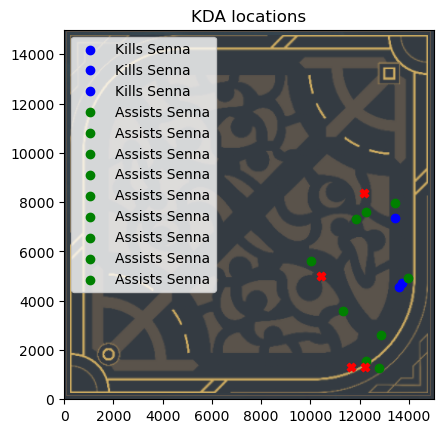

In [208]:
plt.figure()
plt.title('KDA locations')
#plt.grid()

backgroundImage = mpimg.imread('../DataProcessing/TestData/lolMap.PNG')
# Set the limits of the plot
plt.xlim(0, 15000)
plt.ylim(0, 15000)

plt.imshow(backgroundImage, extent=[0, 15000, 0, 15000], alpha=0.8)  # Adjust alpha for transparency

for kill in killDataForParticipant:
    x = kill['position'].get('x', 0)
    y = kill['position'].get('y', 0)
    plt.scatter(x, y, color ='blue', marker='o', label=f"Kills {kill['killerName']}")

for assist in assistDataForParticipant:
    x = assist['position'].get('x', 0)
    y = assist['position'].get('y', 0)
    plt.scatter(x, y, color='green', marker='o', label=f"Assists {assist['assistName']}")
    
for death in deathDataForParticipant:
    x = death['position'].get('x', 0)
    y = death['position'].get('y', 0)
    plt.scatter(x,y, color='red', marker='X')
    
#plt.xlabel('X Coordinate')
#plt.ylabel('Y coordinate')
plt.legend()
plt.show()



In [209]:
def getEventsInMinute(data, targetMinute):
    eventsInMinute = []
    if 'info' in data and 'frames' in data['info']:
        for frame in data['info']['frames']:
            timestamp = frame['timestamp']
            currentMinute = round(timestamp / 60000, 2)  # Round to two decimal places
            if currentMinute == targetMinute:
                eventsInMinute.extend(frame.get('events', []))
    return eventsInMinute



Kills for Senna in minute 2:

Assists for Senna in minute 2:
Timestamp: 0.69, Killer: TahmKench

Deaths for Senna in minute 2:


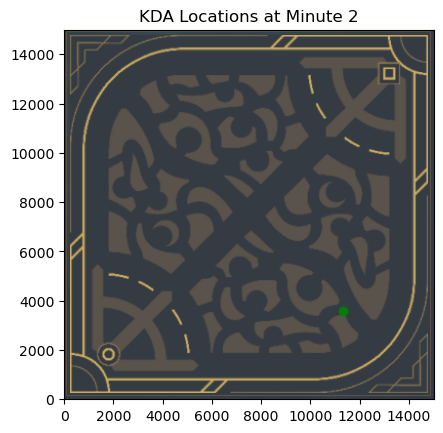

In [217]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plotEventsAtMinute(backgroundImagePath, killData, assistData, deathData, minute, title):
    plt.figure()
    plt.title(f'{title} at Minute {minute}')

    # Load background image
    backgroundImage = mpimg.imread(backgroundImagePath)
    plt.xlim(0, 15000)
    plt.ylim(0, 15000)
    plt.imshow(backgroundImage, extent=[0, 15000, 0, 15000], alpha=0.8)

    # Combine kill, assist, and death data
    allEvents = killData + assistData + deathData

    # Filter events for the specified minute
    minuteEvents = [event for event in allEvents if (event['timestamp']) <= minute]

    # Print kills, assists, and deaths for the target participant in the specified minute
    targetKills = [event for event in minuteEvents if 'killerId' in event and event['killerId'] == targetParticipantId]
    targetAssists = [event for event in minuteEvents if 'assistId' in event and event['assistId'] == targetParticipantId]
    targetDeaths = [event for event in minuteEvents if 'victimId' in event and event['victimId'] == targetParticipantId]

    print(f'\nKills for {targetChampionName} in minute {minute}:')
    for kill in targetKills:
        print(f"Timestamp: {kill['timestamp']}, Victim: {kill['victimName']}")

    print(f'\nAssists for {targetChampionName} in minute {minute}:')
    for assist in targetAssists:
        print(f"Timestamp: {assist['timestamp']}, Killer: {assist['killerName']}")

    print(f'\nDeaths for {targetChampionName} in minute {minute}:')
    for death in targetDeaths:
        print(f"Timestamp: {death['timestamp']}, Killer: {death['killerName']}")

    # Scatter plot for kills, assists, and deaths
    for event in minuteEvents:
        x = event['position']['x']
        y = event['position']['y']

        if 'killerId' in event and event['killerId'] == targetParticipantId:
            plt.scatter(x, y, color='blue', marker='o', label=f"Kills {event['killerName']}")
        elif 'assistId' in event and event['assistId'] == targetParticipantId:
            plt.scatter(x, y, color='green', marker='o', label=f"Assists {event['assistName']}")
        elif 'victimId' in event and event['victimId'] == targetParticipantId:
            plt.scatter(x, y, color='red', marker='X', label=f"Deaths {event['victimName']}")

    #plt.legend()
    plt.show()

# Example usage:
# Assuming killDataForParticipant, assistDataForParticipant, and deathDataForParticipant
# contain the relevant events for kills, assists, and deaths for the target participant
# You can specify the minute you want to see
plotEventsAtMinute('../DataProcessing/TestData/lolMap.PNG', killDataForParticipant, assistDataForParticipant, deathDataForParticipant, 2, 'KDA Locations')


In [225]:
gameStartTimestamp = postData['info']['gameStartTimestamp']
gameEndTimestamp = postData['info']['gameEndTimestamp']

gameDurationMs = gameEndTimestamp - gameStartTimestamp
gameDurationMinutes = gameDurationMs / 60000

def plotEventsAtMinute(backgroundImagePath, killData, assistData, deathData, targetMinute, title):
    plt.figure()
    plt.title(f'{title} at Minute {targetMinute}')

    # Load background image
    backgroundImage = mpimg.imread(backgroundImagePath)
    plt.xlim(0, 15000)
    plt.ylim(0, 15000)
    plt.imshow(backgroundImage, extent=[0, 15000, 0, 15000], alpha=0.8)

    # Combine kill, assist, and death data
    allEvents = killData + assistData + deathData

    # Filter events for the specified minute
    minuteEvents = [event for event in allEvents if (event['timestamp']) <= targetMinute]

    # Print kills, assists, and deaths for the target participant in the specified minute
    targetKills = [event for event in minuteEvents if 'killerId' in event and event['killerId'] == targetParticipantId]
    targetAssists = [event for event in minuteEvents if 'assistId' in event and event['assistId'] == targetParticipantId]
    targetDeaths = [event for event in minuteEvents if 'victimId' in event and event['victimId'] == targetParticipantId]

    print(f'\nKills for {targetChampionName} in minute {targetMinute}:')
    for kill in targetKills:
        print(f"Timestamp: {kill['timestamp']}, Victim: {kill['victimName']}")

    print(f'\nAssists for {targetChampionName} in minute {targetMinute}:')
    for assist in targetAssists:
        print(f"Timestamp: {assist['timestamp']}, Killer: {assist['assistName']}")

    print(f'\nDeaths for {targetChampionName} in minute {targetMinute}:')
    for death in targetDeaths:
        print(f"Timestamp: {death['timestamp']}, Killer: {death['killerName']}")

    # Scatter plot for kills, assists, and deaths
    for event in minuteEvents:
        x = event['position']['x']
        y = event['position']['y']

        if 'killerId' in event and event['killerId'] == targetParticipantId:
            plt.scatter(x, y, color='blue', marker='o', label=f"Kills {event['killerName']}")
        elif 'assistId' in event and event['assistId'] == targetParticipantId:
            plt.scatter(x, y, color='green', marker='o', label=f"Assists {event['assistName']}")
        elif 'victimId' in event and event['victimId'] == targetParticipantId:
            plt.scatter(x, y, color='red', marker='X', label=f"Deaths {event['victimName']}")

    #plt.legend()
    plt.show()

# Example usage:
# Assuming killDataForParticipant, assistDataForParticipant, and deathDataForParticipant
# contain the relevant events for kills, assists, and deaths for the target participant
# You can specify the minute you want to see

interact(
    plotEventsAtMinute,
    backgroundImagePath=widgets.fixed('../DataProcessing/TestData/lolMap.PNG'),
    killData=widgets.fixed(killDataForParticipant),
    assistData=widgets.fixed(assistDataForParticipant),
    deathData=widgets.fixed(deathDataForParticipant),
    targetMinute=widgets.FloatSlider(value=10, min=0, max=gameDurationMinutes, step=1, description='Minute:', readout_format='.1f'),
    title=widgets.fixed('KDA Locations')
)


interactive(children=(FloatSlider(value=10.0, description='Minute:', max=15.249183333333333, readout_format='.…

<function __main__.plotEventsAtMinute(backgroundImagePath, killData, assistData, deathData, targetMinute, title)>